In [1]:
library(knitr)
library(sqldf)
library(ggplot2)
library(mongolite)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)
library(jsonlite)
library(lubridate)
library(gridExtra)
library(GGally)
library(scales)
library(memisc)
 library(sp)
library(rgeos)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(maps)
library(grid)
library(cluster)
#library(clue)
#library(StatMatch)
library(fastcluster)
library(factoextra)
library(FactoMineR)
library(stringr)
library(googleVis)
library(RMySQL)
library(data.table)
library(dbplyr)
library(DBI)
library(httr)
library(scanstatistics)
library(purrr)
library(magrittr)
library(rsatscan)
library(MASS)
library(readr)
library(caret)
library(fitdistrplus)
library(pscl)
library(car)
library(AUC)
library(ROCR)
library(actuar)
#.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths())

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa

Loading required package: lattice
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'memisc'

The following object is masked from 'package:scales':

    percent

The following object is masked from 'package:lubridate':

    is.interval

The following objects are masked from 'package:dplyr':

    collect, recode, rename, syms

The following objec

#### Continuing from STSS_GLM_Baseline_Model_Evaluation and Selection

1. The best baseline model is negative binomial using cities with tootal positive counts >= 130
2. Use scanstatistics zero inflated poisson (scan_eb_zip) for STSS cluster modelling

In [2]:
plot.format <- theme(axis.text = element_text(size = 12), legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.title = element_text(size = 14), plot.title = element_text(size = 14))

In [4]:
count.pos <- read.csv("../STSS/Files/STSS/count_pos2.csv",
         stringsAsFactors = FALSE)

In [9]:
count.pos.pop <- read.csv("../STSS/Files/STSS/count_pos_pop2.csv", 
         stringsAsFactors = FALSE)

In [6]:
count.pos.spat <- read.csv("../STSS/Files/STSS//count_pos_spat2.csv", 
         stringsAsFactors = FALSE)

In [5]:
count.pos.spat.feat <- read.csv("../STSS/Files/STSS/count_pos_spat_feat2.csv", 
         stringsAsFactors = FALSE)

In [3]:
feat.nodup <- read.csv("../STSS/Files/Features/features2dc_nodup.csv", 
          stringsAsFactors = FALSE)

In [237]:
summary(count.pos.pop$positive.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       1      11       3    5236 

In [145]:
nrow(subset(count.pos.spat, positive.counts >= 130))

[1] 197

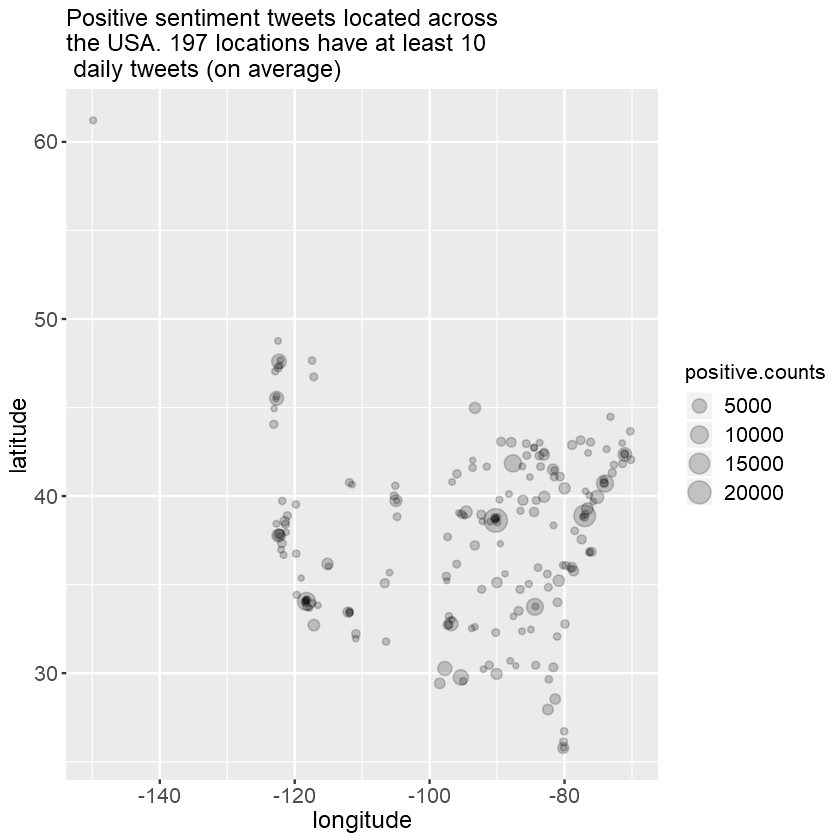

In [7]:
ggplot(aes(y=lat, x=lon), data = subset(count.pos.spat, 
                                        positive.counts >= 130))  +
    geom_point(aes(size = positive.counts), alpha = 0.2) +
    labs(title = "Positive sentiment tweets located across 
the USA. 197 locations have at least 10\n daily tweets (on average)", x = "longitude", 
         y = "latitude") + 

    plot.format

In [10]:
count.130 <- subset(count.pos.spat, positive.counts >= 130)
count.pos.pop.130 <- count.pos.pop %>% 
                        inner_join(count.130["location"], 
                                   by = "location")

In [293]:
negbin <- glm.nb(positive.counts ~ offset(log(totalpopulation)) + time, 
       data = count.pos.pop.130, init.theta = 2, link = "log")

In [208]:
summary(negbin)


Call:
glm.nb(formula = positive.counts ~ offset(log(totalpopulation)) + 
    time, data = count.pos.pop.130, init.theta = 0.5520857168, 
    link = "log")

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.865  -1.074  -0.610  -0.084   8.877  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.306946   0.070168 -132.64   <2e-16 ***
time         0.198213   0.009193   21.56   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.5521) family taken to be 1)

    Null deviance: 2943.6  on 2142  degrees of freedom
Residual deviance: 2692.4  on 2141  degrees of freedom
AIC: 21565

Number of Fisher Scoring iterations: 1


              Theta:  0.5521 
          Std. Err.:  0.0152 

 2 x log-likelihood:  -21558.9060 

In [265]:
pred.negbin <- predict(negbin, data = count.pos.pop.130, type = "response")

In [266]:
mae <- mean(abs(pred.negbin - count.pos.pop.130$positive.counts))
mae

[1] 129.699

In [294]:
count.pos.pop.130$lambda.stss <- predict(negbin.stss, newdata=count.pos.pop.130, 
                         type="response")

In [295]:
count.pos.pop.130$prob.stss <- 
dnbinom(100, mu=count.pos.pop.130$lambda.stss, size=negbin.stss$theta)

### Best k based on demographics and count data (total and positive)

In [160]:
train.2 <- count.pos.pop.130 %>% dplyr::select(-location, -yday, 
                                             -counts,
                                              -location_total.counts,
                                           -negative.counts, 
                                              -neutral.counts)

In [161]:
colnames(train.2)

[1] "time"            "positive.counts" "lon"             "lat"            
[5] "totalpopulation"

In [162]:
train.2.scale <- scale(train.2, center = TRUE, scale = TRUE)

In [12]:
kgrid <- expand.grid(k = seq(5, 101, 2)) 

In [13]:
set.seed(20190126)
ctrl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
knn.results <- train(positive.counts ~., data = train.2.scale, method = "knn", #tuneLength = 20, 
                    tuneGrid = kgrid)

In [14]:
knn.results

k-Nearest Neighbors 

6218 samples
   4 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 6218, 6218, 6218, 6218, 6218, 6218, ... 
Resampling results across tuning parameters:

  k    RMSE       Rsquared   MAE      
    5  0.8365632  0.3163346  0.1718583
    7  0.8275082  0.3061230  0.1697520
    9  0.8264956  0.2991128  0.1693827
   11  0.8301866  0.2895311  0.1700160
   13  0.8316648  0.2829013  0.1694429
   15  0.8304342  0.2800184  0.1692548
   17  0.8289528  0.2774543  0.1687381
   19  0.8258051  0.2799610  0.1676159
   21  0.8248679  0.2791998  0.1667539
   23  0.8239595  0.2791886  0.1661931
   25  0.8249226  0.2766464  0.1663215
   27  0.8251028  0.2760815  0.1661859
   29  0.8265447  0.2732521  0.1660740
   31  0.8284158  0.2698063  0.1661270
   33  0.8303286  0.2670958  0.1663401
   35  0.8315674  0.2648746  0.1664119
   37  0.8330455  0.2626056  0.1665893
   39  0.8347072  0.2599884  0.1665461
   41  0.8362053  0.2574857  0.1665471
   

### Spatiotemporal - Scanstatistics

In [269]:
summary(count.pos.pop.130$positive.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.00   22.00   96.05   63.00 5236.00 

In [ ]:
#### Create knn matrix

In [296]:
knn_mat <- coords_to_knn(unique(count.pos.pop.130[c("lon", "lat")]), 5)

######## Create zones based on knn results

In [26]:
nrow(count.pos.pop)

[1] 22407

In [297]:
zones <- knn_zones(knn_mat)

In [302]:
count.pos.mat <- df_to_matrix(count.pos.pop.130, "time", "location", 
                              "positive.counts")

In [303]:
population <- df_to_matrix(count.pos.pop.130, "time", "location", 
                           "totalpopulation")

In [304]:
baselines.mat <- df_to_matrix(count.pos.pop.130, "time", "location",
                              "lambda.stss")

In [305]:
probs.mat <- df_to_matrix(count.pos.pop.130, "time", "location", "prob.stss")

In [306]:
### Remove NAs

In [307]:
for (i in 1:ncol(count.pos.mat)) {
    
   count.pos.mat[ , i] <- ifelse(is.na(count.pos.mat[ , i]), 
                                 0, count.pos.mat[ , i])
}

In [308]:
for (i in 1:ncol(population)) {
    
   population[ , i] <- ifelse(is.na(population[ , i]), 
                                 0, population[ , i])
}

In [309]:
for (i in 1:ncol(baselines.mat)) {
    
   baselines.mat[ , i] <- ifelse(is.na(baselines.mat[ , i]), 
                                 0.1, baselines.mat[ , i])
}

In [310]:
for (i in 1:ncol(probs.mat)) {
    
   probs.mat[ , i] <- ifelse(is.na(probs.mat[ , i]) | 
                             probs.mat[ , i] == 0, 10e-8, 
                             probs.mat[ , i])
   # print (i)
}

In [311]:
set.seed(20181110)
sp_results.zip <- scan_eb_zip(counts =  count.pos.mat,
zones = zones,
baselines = baselines.mat, # + 1,
probs = probs.mat,
population = population,
n_mcsim = 100,
max_only = FALSE)

In [312]:
sp_results.zip

Data distribution:                zero-inflated Poisson
Type of scan statistic:           expectation-based
Setting:                          univariate
Number of locations considered:   194
Maximum duration considered:      12
Number of spatial zones:          715
Number of Monte Carlo replicates: 100
Monte Carlo P-value:              0.01
Gumbel P-value:                   0
Most likely event duration:       11
ID of locations in MLC:           173

In [108]:
saveRDS(sp_results.zip, "C:\\MathLabASUS\\Courses\\Ryerson\\Project\\Data\\Files\\STSS\\Project\\nb_sp_results.zip.130.rds")

In [ ]:
##### Get p-values of top clusters

In [315]:
get.top.100 <- top_clusters(sp_results.zip, zones, k = 100, FALSE)

In [316]:
get.top.100 

,zone,duration,score,relrisk,n_iter,Gumbel_pvalue
1,656,11,63946.2704,50.972897,2,0
7,63,11,40947.7528,16.016541,2,0
23,695,10,35581.7739,20.719659,2,0
116,51,10,14358.6839,14.425815,2,0
215,337,7,6646.1476,3.466224,2,0
271,554,7,5144.1482,6.906939,2,0
343,115,7,3658.6109,5.814704,2,0
383,179,7,3363.7114,4.205022,2,0
392,77,7,3306.7807,2.754523,2,0
451,524,7,2962.6463,2.409242,2,0


In [ ]:
### Get cities in these clusters

In [317]:
scores <- score_locations(sp_results.zip, zones)

In [285]:
head(scores %>% arrange(desc(score)))

location,score,n_zones,relative_score
173,319.6643,10,1.0000000
13,201.7090,13,0.6310024
40,155.2125,14,0.4855484
15,139.9263,13,0.4377289
188,133.8069,5,0.4185857
71,107.8446,9,0.3373683


In [318]:
locations <- count.pos.pop.130$location

In [319]:
locations.top.100 <- get.top.100$zone %>%
purrr::map(get_zone, zones = zones) %>%
purrr::map(function(x) locations[x])

In [324]:
#cities.nb.zip <- 
get.top.100 %>% mutate(cities = locations.top.100) %>%
                arrange(desc(relrisk)) #%>% dplyr::select(duration, cities)
                   # 
                

zone,duration,score,relrisk,n_iter,Gumbel_pvalue,cities
184,10,983.78463,178.148507,4,0,ATLANTA GA
656,11,63946.27036,50.972897,2,0,ROCHESTER NY
56,7,923.37604,27.471696,2,0,COLUMBIA SC
695,10,35581.77391,20.719659,2,0,SCOTTSDALE AZ
63,11,40947.75283,16.016541,2,0,"CINCINNATI OH, COLUMBUS OH , DAYTON OH , ROCHESTER NY"
51,10,14358.68393,14.425815,2,0,COLUMBIA MO
259,10,253.61217,8.080083,3,0,BURLINGTON VT
227,10,208.18160,7.153130,2,0,BEVERLY HILLS CA
554,7,5144.14822,6.906939,2,0,"MINNEAPOLIS MN, MONTGOMERY AL , PROVIDENCE RI"
277,7,134.17111,6.838798,3,0,CHAPEL HILL NC


In [ ]:
saveRDS(sp_result.zip, "../STSS/Files/STSS/sp_nb_zip_pop130v2.rds")

In [323]:
saveRDS(cities.nb.zip, "../STSS/Files/STSS/cities_nb_zip_pop130v2.rds")